In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [2]:
import pandas as pd

df = pd.read_excel(r'C:\Users\Dhruv Kumar Jha\Downloads\Graphene AI\Unsupervised-Text-Clustering using NLP\interns-dataset.xlsx')
df

,cluster_id,id,phrase
0,0,0334a0d055104e9a931c079e338be9a1,Would use the product again if needed Joe .
1,0,796d6c25ab8849cbba427f1f3e250d80,Have been using the product for a week now
2,0,661f5299cd8944a8a3841fd4f049dee9,Will continue to use this product when I have a issue .
3,0,da831e4bc58d4505aec3c583f0248f8b,Have always had good luck with this product .
4,0,0ea997675e7344419d1540d3e0bc26c3,Will continue to use This product as This product gets the job done .
...,...,...,...
599,10,93f874167d11473f8d36d1cda0a0081c,Spray has no strong odor
600,10,d50fe37fab064408a891aa9ef45dcd70,Spray is nice to keep out on the porch on a summer day
601,10,3e1e8901d5ab4fc9b602ecfdca1220cb,Spray does not leave any oily stinky stains
602,10,c84e1b1196a242d18938af6c60403afc,Love that the scent of this spray is not chemical smelling .


In [3]:
df.drop(df.columns[[1]], axis=1, inplace=True)
df

,cluster_id,phrase
0,0,Would use the product again if needed Joe .
1,0,Have been using the product for a week now
2,0,Will continue to use this product when I have a issue .
3,0,Have always had good luck with this product .
4,0,Will continue to use This product as This product gets the job done .
...,...,...
599,10,Spray has no strong odor
600,10,Spray is nice to keep out on the porch on a summer day
601,10,Spray does not leave any oily stinky stains
602,10,Love that the scent of this spray is not chemical smelling .


In [4]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["phrase_clean"] = df["phrase"].apply(lambda x: clean_text(x))

df

Wall time: 2.36 s


,cluster_id,phrase,phrase_clean
0,0,Would use the product again if needed Joe .,would use product need joe
1,0,Have been using the product for a week now,use product week
2,0,Will continue to use this product when I have a issue .,continue use product issue
3,0,Have always had good luck with this product .,always good luck product
4,0,Will continue to use This product as This product gets the job done .,continue use product product get job do
...,...,...,...
599,10,Spray has no strong odor,spray strong odor
600,10,Spray is nice to keep out on the porch on a summer day,spray nice keep porch summer day
601,10,Spray does not leave any oily stinky stains,spray leave oily stinky stain
602,10,Love that the scent of this spray is not chemical smelling .,love scent spray chemical smelling


In [5]:
X = df['phrase_clean']
X

0                   would use product need joe
1                             use product week
2                   continue use product issue
3                     always good luck product
4      continue use product product get job do
                        ...                   
599                          spray strong odor
600           spray nice keep porch summer day
601              spray leave oily stinky stain
602         love scent spray chemical smelling
603                   bug spray smell nauseate
Name: phrase_clean, Length: 604, dtype: object

In [6]:
len(X)

604

## LDA with Scikit-learn


In [7]:
count_vectorizer = CountVectorizer(ngram_range = (1, 2), max_df = 500, min_df = 10)

transformed_vector = count_vectorizer.fit_transform(X)
transformed_vector.shape

(604, 66)

In [8]:
feature_names = count_vectorizer.get_feature_names()
feature_names[0:20]

['also',
 'ant',
 'around',
 'around child',
 'around kid',
 'around pet',
 'away',
 'bad',
 'bug',
 'buy',
 'chemical',
 'chemical smell',
 'child',
 'control',
 'definitely',
 'delivery',
 'effective',
 'exterminator',
 'fast',
 'friend']

In [9]:
%%time

perplexities = []
for NUM_TOPICS in range(5, 101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    perplexities.append(lda_model.perplexity(transformed_vector))

Wall time: 1min 52s


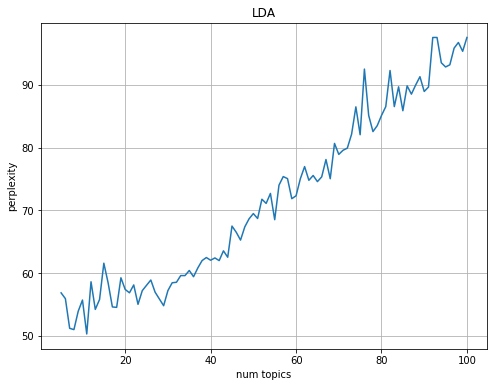

In [10]:
x = range(5, 101)
y = perplexities

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'perplexity', title = 'LDA')
ax.grid()

plt.show()

In [11]:
%%time

scores = []
for NUM_TOPICS in range(5,101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    scores.append(lda_model.score(transformed_vector))

Wall time: 2min 1s


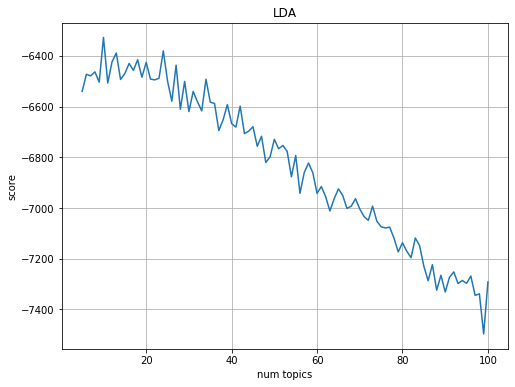

In [12]:
x = range(5, 101)
y = scores

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'score', title = 'LDA')
ax.grid()

plt.show()

Some literature suggests that it might be possible to use perplexity (https://en.wikipedia.org/wiki/Perplexity) to determine an optimal number of topics, but others have questioned relying on it. Regardless, the scikit-learn implementation appears to still have a bug(https://github.com/scikit-learn/scikit-learn/issues/6777) that makes the perplexity value unreliable.

In [13]:
NUM_TOPICS = 11

lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)

lda = lda_model.fit_transform(transformed_vector)
lda.shape

(604, 11)

In [14]:
sum(lda[0])

1.0

In [15]:
lda_model.components_.shape

(11, 66)

In [16]:
lda_model.score(transformed_vector)

-6405.9192560366255

In [17]:
def print_topic(identifier, top_words=10):
    for topic_id, topic_word_probs in enumerate(lda_model.components_):
        if topic_id == identifier:
            print(f"Topic {topic_id}: ")
            
            top_feature_names = [feature_names[i] for i in topic_word_probs.argsort()[: -top_words - 1: -1]]
            
            print(" ".join(top_feature_names))

In [18]:
for i in range(NUM_TOPICS):
    print_topic(i, top_words=10)

Topic 0: 
safe pet around kid friendly safe around around kid use pet friendly around pet
Topic 1: 
year use keep hot shot hot shot time roach product away
Topic 2: 
ant exterminator get see around definitely money insect year buy
Topic 3: 
good bug friend value money recommend stuff away see insect
Topic 4: 
great price value money also product good stuff well use
Topic 5: 
smell delivery fast like bad nice odor lemon also spray
Topic 6: 
pest odor control pest control chemical effective smell chemical smell spray strong
Topic 7: 
recommend would spray product would recommend definitely buy recommend product friend pest
Topic 8: 
safe child love around use safe use around child use around safe around also
Topic 9: 
product scent use strong use product stuff also insect nice lemon
Topic 10: 
work well worth work well product price money definitely stuff lemon


In [19]:
topics = []

for i in range(len(X)):
    topics.append(lda[i].argmax())

In [20]:
df['topic'] = topics

df

,cluster_id,phrase,phrase_clean,topic
0,0,Would use the product again if needed Joe .,would use product need joe,9
1,0,Have been using the product for a week now,use product week,9
2,0,Will continue to use this product when I have a issue .,continue use product issue,9
3,0,Have always had good luck with this product .,always good luck product,3
4,0,Will continue to use This product as This product gets the job done .,continue use product product get job do,9
...,...,...,...,...
599,10,Spray has no strong odor,spray strong odor,6
600,10,Spray is nice to keep out on the porch on a summer day,spray nice keep porch summer day,1
601,10,Spray does not leave any oily stinky stains,spray leave oily stinky stain,7
602,10,Love that the scent of this spray is not chemical smelling .,love scent spray chemical smelling,6


In [21]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
lda_2d_tsne = tsne.fit_transform(lda)
lda_df_tsne = pd.DataFrame(lda_2d_tsne)
lda_df_tsne.shape

(604, 2)

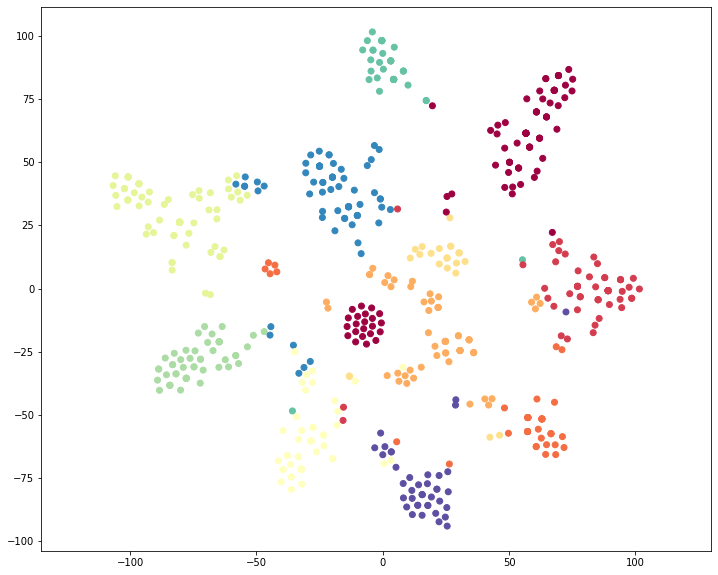

In [22]:
plt.subplots(figsize=(12, 10))
plt.axis('equal')

plt.scatter(lda_df_tsne[0], lda_df_tsne[1], c=df['topic'], cmap = plt.cm.Spectral)

In [23]:
df.to_excel("output.xlsx")